<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/ConceptSHAP_Clean_shapruntime_issues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XAI for DRM in Wildfire: POC.

Masterthesis - Sarah S. Ziegenhagen

---


## Imports and installments

In [1]:
# install required libraries
!pip install tf-keras-vis
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 39.0 MB/s eta 0:00:00


In [2]:
# import required libraries
import tensorflow as tf
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from keras.models import Model
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from tensorflow_datasets.core import lazy_builder_import
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import shap
from sklearn.model_selection import train_test_split


## Data loading

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle-2.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle-2.json': No such file or directory
ref                                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                      9KB  2024-08-17 06:57:57           3503         81  0.9411765        
mrmars1010/filpkart-mobiles                                          Flipkart Products Sales: Mobiles Dataset 📱         108KB  2024-08-24 04:31:50           1055         25  0.88235295       
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                         

In [4]:
# download and unzip the wildfire occurence dataset
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset
! unzip wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

In [5]:
# download and unzip the landuse-concept dataset
! kaggle datasets download apollo2506/landuse-scene-classification
! mkdir -p concepts
! unzip landuse-scene-classification.zip -d concepts

Streaming output truncated to the last 5000 lines.
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000365.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000366.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000367.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000368.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000369.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000371.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000372.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000374.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000376.png  
  inflating: concepts/images_train_test_val/train/mediumre

### Inspect the data

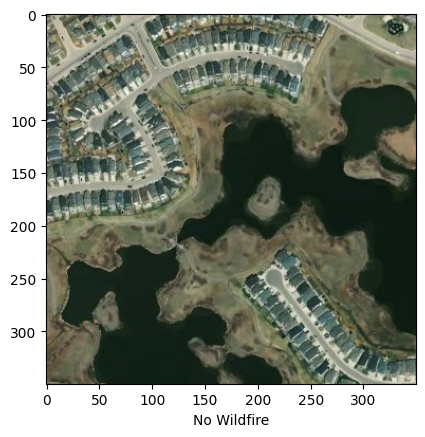

In [6]:
# Inspect the wildfire occurence data
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/test/nowildfire/-113.91777,50.901087.jpg" #nowildire
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
plt.xlabel("No Wildfire")
plt.show()

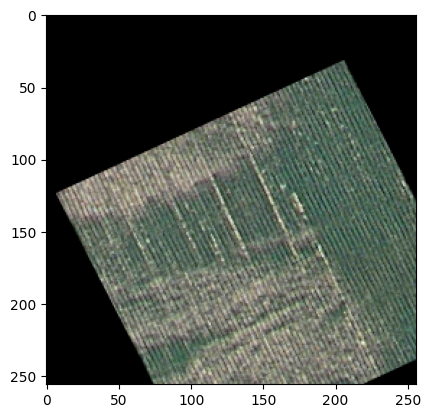

In [7]:
# Inspect the landuse concept data
test_img_path = "/content/concepts/images/agricultural/agricultural_000001.png" #agricultural
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Agricultural")
plt.show()

### Create data generators

In [ ]:
# define generator to load the data into the datasets during training
class CustomDataGenerator(Sequence):
    """
    Custom data generator for loading images and their corresponding labels.
    """

    def __init__(self, directory, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True):
        """
        Initialize the CustomDataGenerator.
        Args:
          directory: directory of the images
          batch_size: batch size for the training
          target_size: target size of the images
          class_mode:  categorical or binary
          shuffle: shuffle the data, true or false
        """
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle

        self.classes = sorted(os.listdir(directory))
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths, self.labels = self._get_image_paths_and_labels()

        self.on_epoch_end()

    def _get_image_paths_and_labels(self):
        """
        Get the image paths and labels from the directory.
        Returns:
          image_paths: list of image paths
          labels: list of labels
        """
        image_paths = []
        labels = []
        for cls in self.classes:
            cls_dir = os.path.join(self.directory, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.startswith('.'):  # Skip hidden files
                    continue
                image_paths.append(os.path.join(cls_dir, img_name))
                labels.append(self.class_indices[cls])
        return image_paths, labels

    def __len__(self):
        """
        Get the number of batches per epoch.
        Returns:
          number of batches per epoch
        """
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """
        Get a batch of images and their corresponding labels.
        Args:
          index: index of the batch
        Returns:
          images: batch of images
          labels: batch of labels
        """
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([self._load_image_opencv(img_path) for img_path in batch_image_paths])
        labels = np.array(batch_labels)

        if self.class_mode == 'categorical':
            labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.classes))

        return images, labels

    def on_epoch_end(self):
        """
        Shuffle the data at the end of each epoch.
        """
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)
            self.image_paths = list(self.image_paths)
            self.labels = list(self.labels)

    def _load_image_opencv(self, img_path):
        """
        Load an image using OpenCV and preprocess it.
        Args:
          img_path: path to the image
        Returns:
          image: loaded image
        """
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, self.target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize the image
        return img

In [ ]:
# create the training and validation generators
train_generator = CustomDataGenerator('/content/train', batch_size=16, target_size=(224, 224))
val_generator = CustomDataGenerator('/content/valid', batch_size=16, target_size=(224, 224))

## Load the model

In [8]:
# Load the pre-trained wildfire occurrence classification model
# Model was fine-tuned on ResNet50 architecture with input size 224x224 pixels
wildfire_occurence_model = load_model('resent50_finetuned_224.keras')

In [9]:
# Check model architecture
wildfire_occurence_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,237,960 (161.13 MB)

 Trainable params: 9,193,858 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 18,387,718 (70.14 MB)

## XAI Method: ConceptSHAP
In ConceptSHAP, the goal is to explain a model's decision-making process in terms of concepts rather than individual features. To do this, meaningful representations (concept activations) neeed to be extracted from the input data. These are are typically taken from intermediate layers of the model. Hence, first a new model without the final classifiation layers is created from the wildfire occurence model.

ConceptSHAP uses these intermediate concept activations to represent data in a lower-dimensional, concept-based space and then attributes importance to each concept using Shapley values.

In [10]:
# From the trained model, create a model without the classification layers.
# Used to extract the concept activations.
intermediate_layer_model = tf.keras.Model(inputs=wildfire_occurence_model.input,
                                          outputs=wildfire_occurence_model.get_layer('global_average_pooling2d').output)

## Extract the concept activations

### Load and preprocess the data

In [11]:
# Define function to preprocess and load images of the concept dataset
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    """
    Load and preprocess images from a directory. The classes are identified based on the directory structure.
    In the dataset, the classes are the human understandable concepts.
    Args:
      concepts_dir: directory of the images
      target_size: target size of the images (default is 224,224)
      batch_size: batch size for the training (default is 32)
    Yields:
      np.ndarray: Batch of processed images.
      list: Corresponding labels for the images in the batch.
      list: Corresponding image paths in the batch.
    """
    image_paths = []
    labels = []

    # Get sorted list of concept classes based on directory names
    classes = sorted(os.listdir(concepts_dir))
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Print the identified classes (concept names)
    print(f"Identified classes (concepts): {classes}")

    # Traverse through directories and collect image paths and labels
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                class_name = os.path.basename(root)
                image_paths.append(os.path.join(root, file))
                labels.append(class_indices[class_name])

    print(f"Found {len(image_paths)} images in {concepts_dir}.")

    # Batch processing: Iterate through image paths and process in batches
    for start_idx in range(0, len(image_paths), batch_size):
        images = []
        batch_image_paths = image_paths[start_idx:start_idx + batch_size]
        batch_labels = labels[start_idx:start_idx + batch_size]


        # Process the current batch of images
        for img_path in batch_image_paths:
          img = cv2.imread(img_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, target_size)
          img = img.astype('float32') / 255.0
          images.append(img)

        # Convert list of images to a NumPy array for better performance with model input
        images = np.array(images)

        # Yield the batch of processed images, labels, and image paths
        yield images, batch_labels, batch_image_paths


In [12]:
# Load and preprocess images from the concept dataset
concepts_dir = '/content/concepts/images_train_test_val/train'
total_processed_images = 0


# Iterate over the dataset in batches
for processed_images, batch_labels, batch_image_paths in load_and_preprocess_images(concepts_dir):
    # Process each batch as needed
    total_processed_images += len(processed_images)
    print(f"Processed batch of {len(processed_images)} images")
    print(f"Total number of processed images: {total_processed_images}")

Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
Processed batch of 32 images
Total number of processed images: 32
Processed batch of 32 images
Total number of processed images: 64
Processed batch of 32 images
Total number of processed images: 96
Processed batch of 32 images
Total number of processed images: 128
Processed batch of 32 images
Total number of processed images: 160
Processed batch of 32 images
Total number of processed images: 192
Processed batch of 32 images
Total number of processed images: 224
Processed batch of 32 images
Total number of processed images: 256
Processed batch of 32 images
Total number of processed images: 288
P

### Check that the data was processed correctly

In [13]:
# Check if the lables are handled correctly
# Initialize the generator again
concept_generator = load_and_preprocess_images(concepts_dir='/content/concepts/images_train_test_val/train')
all_labels = []

# Collect the labels from each batch
for _, batch_labels, _ in concept_generator:
    all_labels.extend(batch_labels)

all_labels = np.array(all_labels)

# Check the shape of the labels array. Should be one label for each of the 7350 images
print("Labels shape:", all_labels.shape)

# Get the unique labels
unique_labels = np.unique(all_labels)
print("Unique labels:", unique_labels)

Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
Labels shape: (7350,)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [14]:
# Match the concepts to the labels for better understanding later on
concept_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                 'storagetanks', 'tenniscourt']

# Print out the mapping of labels to concept names
print("\nMapping of labels to concept names:")
for i, concept in enumerate(concept_names):
    print(f"Label {i}: {concept}")

# Check that all labels correspond to valid concept names
invalid_labels = [label for label in unique_labels if label >= len(concept_names)]
if invalid_labels:
    print(f"Warning: Found invalid labels that don't map to concept names: {invalid_labels}")
else:
    print("All labels map correctly to concept names.")


Mapping of labels to concept names:
Label 0: agricultural
Label 1: airplane
Label 2: baseballdiamond
Label 3: beach
Label 4: buildings
Label 5: chaparral
Label 6: denseresidential
Label 7: forest
Label 8: freeway
Label 9: golfcourse
Label 10: harbor
Label 11: intersection
Label 12: mediumresidential
Label 13: mobilehomepark
Label 14: overpass
Label 15: parkinglot
Label 16: river
Label 17: runway
Label 18: sparseresidential
Label 19: storagetanks
Label 20: tenniscourt
All labels map correctly to concept names.


In [15]:
# Check the distribution of labels. Should be 350 each
unique, counts = np.unique(all_labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print("\nLabel distribution:")
for label, count in label_distribution.items():
    print(f"Label {label} ({concept_names[label]}): {count} images")


Label distribution:
Label 0 (agricultural): 350 images
Label 1 (airplane): 350 images
Label 2 (baseballdiamond): 350 images
Label 3 (beach): 350 images
Label 4 (buildings): 350 images
Label 5 (chaparral): 350 images
Label 6 (denseresidential): 350 images
Label 7 (forest): 350 images
Label 8 (freeway): 350 images
Label 9 (golfcourse): 350 images
Label 10 (harbor): 350 images
Label 11 (intersection): 350 images
Label 12 (mediumresidential): 350 images
Label 13 (mobilehomepark): 350 images
Label 14 (overpass): 350 images
Label 15 (parkinglot): 350 images
Label 16 (river): 350 images
Label 17 (runway): 350 images
Label 18 (sparseresidential): 350 images
Label 19 (storagetanks): 350 images
Label 20 (tenniscourt): 350 images


### Extract the concept activations

In [16]:
# Extract the concept activations: embeddings from the intermediate layer
def extract_concept_activations(model, image_generator):
    """
    Extract concept activations: from the intermediate layer using the modified model, processing images in batches.
    Args:
      model: The modified model without the classification layer.
      image_generator: A generator that yields batches of preprocessed images.
    Returns:
      concept_activations:: A NumPy array containing the extracted concept activations for all images.
    """
    all_concept_activations = []

    # Process each batch of images yielded by the generator
    for images_batch, _, _ in image_generator:
        batch_features = model.predict(images_batch)
        all_concept_activations.append(batch_features)

    # Concatenate all feature batches into a single NumPy array
    concept_activations = np.concatenate(all_concept_activations, axis=0)

    return concept_activations

In [17]:
# Initialize the generator
concept_generator = load_and_preprocess_images(concepts_dir='/content/concepts/images_train_test_val/train', batch_size=32)

In [18]:
# Extract concept activations from the intermediate layer using the modified model
concept_activations = extract_concept_activations(intermediate_layer_model, concept_generator)

# Print a confirmation and the shape of the extracted concept activations
print("Concept activation extraction complete. Activation shape:", concept_activations.shape)

Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

### Inspect the activations



In [19]:
# Check the shape of the concept activations.
# Should be one activation of 224x224 = 2048 features for each of the 7350 images.
print("Concept activations shape:", concept_activations.shape)

Concept activations shape: (7350, 2048)


In [20]:
# Check the type of the concept activations
print("Concept activations dtype:", concept_activations.dtype)

Concept activations dtype: float32


In [21]:
# Check for NaNs or Infinities in the concept activations
# Should be none
has_nan = np.isnan(concept_activations).any()
has_inf = np.isinf(concept_activations).any()

print(f"Contains NaNs: {has_nan}")
print(f"Contains Infinities: {has_inf}")

Contains NaNs: False
Contains Infinities: False


In [22]:
# Check the range of values in the concept activations
print("Min activation value:", np.min(concept_activations))
print("Max activation value:", np.max(concept_activations))
print("Mean activation value:", np.mean(concept_activations))

Min activation value: 0.0
Max activation value: 13.013338
Mean activation value: 0.21213941


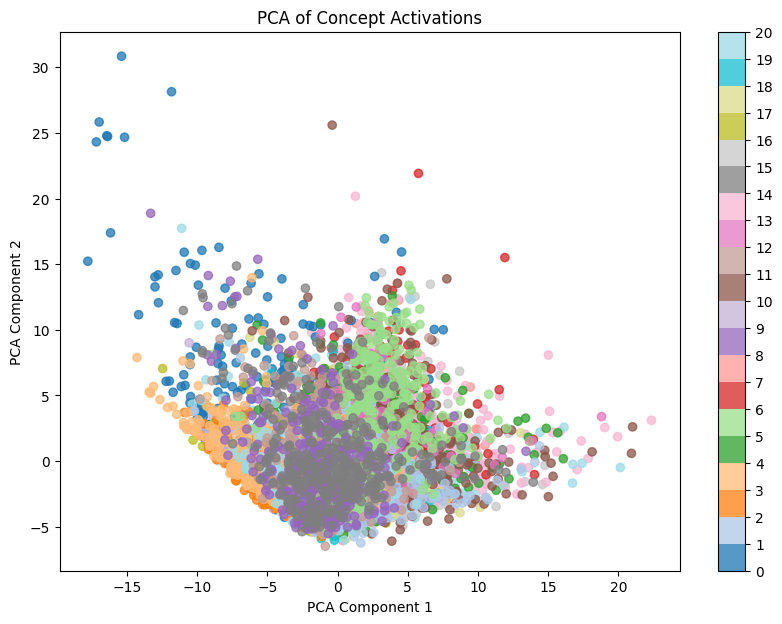

In [23]:
# Perform PCA to reduce the activations to 2 components
# The goal is to get some understanding for the reasonability of the activations.
pca = PCA(n_components=2)
reduced_activations = pca.fit_transform(concept_activations)

# Plot the reduced activations, colored by concept label
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=all_labels, cmap='tab20', alpha=0.75)
plt.colorbar(scatter, ticks=np.arange(len(concept_names)))
plt.title("PCA of Concept Activations")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


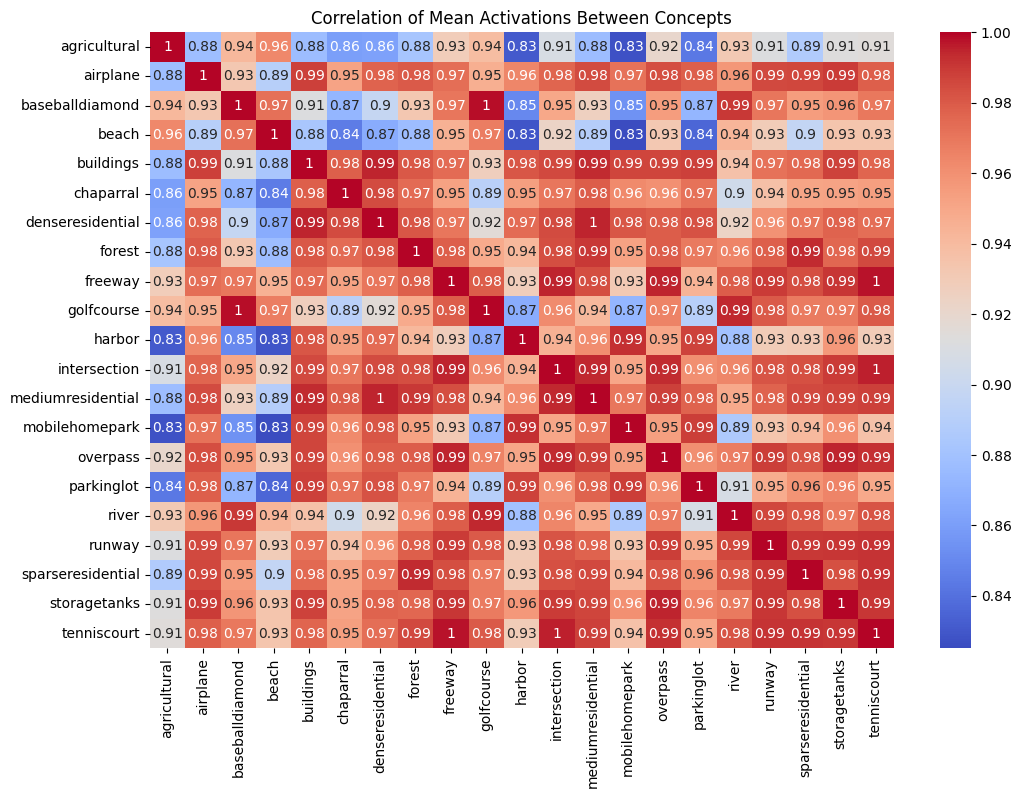

In [24]:
# Calculate the correlation between mean activations for each concept
mean_activations = {}

# Calculate mean activations per concept
for label in np.unique(all_labels):
    concept_indices = np.where(all_labels == label)[0]
    mean_activations[label] = np.mean(concept_activations[concept_indices], axis=0)

mean_activations_matrix = np.array([mean_activations[label] for label in np.unique(all_labels)])
correlation_matrix = np.corrcoef(mean_activations_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=concept_names, yticklabels=concept_names)
plt.title("Correlation of Mean Activations Between Concepts")
plt.show()

### Using the concept embeddings, create a binary classifier to detect the presence of these concepts

In [25]:
# Dictionary to store trained classifiers
concept_classifiers = {}

# Loop over each concept
for concept_idx, concept_name in enumerate(concept_names):
    print(f"Training classifier for concept: {concept_name}")

    # Create binary labels for the concept (1 if the concept is present, 0 otherwise)
    concept_labels = (all_labels == concept_idx).astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(concept_activations, concept_labels, test_size=0.2, random_state=42)

    # Train a logistic regression model for this concept
    clf = LogisticRegression(solver='liblinear')
    clf.fit(X_train, y_train)

    # Store the classifier in the dictionary
    concept_classifiers[concept_name] = clf

    # Evaluate the classifier on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy for {concept_name}: {accuracy:.4f}")


Training classifier for concept: agricultural
Accuracy for agricultural: 0.9789
Training classifier for concept: airplane
Accuracy for airplane: 0.9701
Training classifier for concept: baseballdiamond
Accuracy for baseballdiamond: 0.9510
Training classifier for concept: beach
Accuracy for beach: 0.9646
Training classifier for concept: buildings
Accuracy for buildings: 0.9483
Training classifier for concept: chaparral
Accuracy for chaparral: 0.9864
Training classifier for concept: denseresidential
Accuracy for denseresidential: 0.9449
Training classifier for concept: forest
Accuracy for forest: 0.9626
Training classifier for concept: freeway
Accuracy for freeway: 0.9551
Training classifier for concept: golfcourse
Accuracy for golfcourse: 0.9395
Training classifier for concept: harbor
Accuracy for harbor: 0.9748
Training classifier for concept: intersection
Accuracy for intersection: 0.9558
Training classifier for concept: mediumresidential
Accuracy for mediumresidential: 0.9517
Training

In [26]:
# Loop through classifiers to print detailed evaluation metrics
for concept_name, clf in concept_classifiers.items():
    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Print a detailed classification report
    print(f"Classification report for {concept_name}:")
    print(classification_report(y_test, y_pred))


Classification report for agricultural:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1408
           1       0.00      0.00      0.00        62

    accuracy                           0.92      1470
   macro avg       0.48      0.48      0.48      1470
weighted avg       0.92      0.92      0.92      1470

Classification report for airplane:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1408
           1       0.00      0.00      0.00        62

    accuracy                           0.93      1470
   macro avg       0.48      0.49      0.48      1470
weighted avg       0.92      0.93      0.92      1470

Classification report for baseballdiamond:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1408
           1       0.09      0.05      0.06        62

    accuracy                           0.94      1470
   macro 

### Calculate the Shapely Values

In [29]:
# Using the concept activations extracted earlier as input images
all_images_train = concept_activations
all_labels_train = all_labels

# Set the total number of samples due to computation power restrains (5 samples
# per class, 21 classes)
subset_size = 105

# Perform stratified sampling for background data
background_sample, _, background_labels, _ = train_test_split(all_images_train, all_labels_train,
                                                              stratify=all_labels_train,
                                                              train_size=subset_size,
                                                              random_state=42)

# Perform stratified sampling for test data
test_sample, _, test_labels, _ = train_test_split(all_images_train, all_labels_train,
                                                  stratify=all_labels_train,
                                                  train_size=subset_size,
                                                  random_state=42)


In [32]:
# List of all concept names
all_concept_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                     'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                     'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                     'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                     'storagetanks', 'tenniscourt']

# Define the subset of concepts you want to analyze
subset_concepts = ['agricultural', 'beach', 'forest', 'freeway', 'river', 'sparseresidential', 'denseresidential', 'harbor']

# Create a mapping from concept names to indices
concept_to_index = {name: idx for idx, name in enumerate(all_concept_names)}
subset_indices = [concept_to_index[concept] for concept in subset_concepts]


In [33]:
# Filter the labels and activations
filtered_labels = np.array([label for label in all_labels if label in subset_indices])
filtered_activations = np.array([activation for activation, label in zip(concept_activations, all_labels) if label in subset_indices])


In [34]:
print("Concept to index mapping:")
for concept in subset_concepts:
    print(f"{concept}: {concept_to_index[concept]}")


Concept to index mapping:
agricultural: 0
beach: 3
forest: 7
freeway: 8
river: 16
sparseresidential: 18
denseresidential: 6
harbor: 10


In [37]:
# Dictionary to store trained classifiers for the subset
subset_concept_classifiers = {}

# Loop over each concept in the subset
for concept_idx, concept_name in enumerate(subset_concepts):
    print(f"Training classifier for concept: {concept_name}")

    # Create binary labels for the concept (1 if the concept is present, 0 otherwise)
    concept_labels = (filtered_labels == subset_indices[concept_idx]).astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(filtered_activations, concept_labels, test_size=0.2, random_state=42)

    # Train a logistic regression model for this concept
    clf = LogisticRegression(solver='liblinear')
    clf.fit(X_train, y_train)

    # Store the classifier in the dictionary
    subset_concept_classifiers[concept_name] = clf

    # Evaluate the classifier on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy for {concept_name}: {accuracy:.4f}")


Training classifier for concept: agricultural
Accuracy for agricultural: 0.9411
Training classifier for concept: beach
Accuracy for beach: 0.9375
Training classifier for concept: forest
Accuracy for forest: 0.9643
Training classifier for concept: freeway
Accuracy for freeway: 0.9107
Training classifier for concept: river
Accuracy for river: 0.8911
Training classifier for concept: sparseresidential
Accuracy for sparseresidential: 0.9143
Training classifier for concept: denseresidential
Accuracy for denseresidential: 0.9250
Training classifier for concept: harbor
Accuracy for harbor: 0.9696


In [38]:
# Define background and test sample sizes. Subset of 8 concepts with 5 images each.
background_sample_size = 40
test_sample_size = 40

# Perform stratified sampling for background data
background_sample, _, _, _ = train_test_split(filtered_activations, filtered_labels,
                                              stratify=filtered_labels,
                                              train_size=background_sample_size,
                                              random_state=42)

# Perform stratified sampling for test data
test_sample, _, _, _ = train_test_split(filtered_activations, filtered_labels,
                                        stratify=filtered_labels,
                                        train_size=test_sample_size,
                                        random_state=42)


In [39]:
# Dictionary to hold Shapley values for each concept
subset_concept_shap_values = {}

# Loop through the subset concept classifiers and compute Shapley values for each
for concept_name, clf in subset_concept_classifiers.items():
    print(f"Computing Shapley values for concept: {concept_name}")

    # Create SHAP explainer with stratified background sample
    explainer = shap.KernelExplainer(clf.predict_proba, background_sample)

    # Compute the Shapley values for the stratified test set
    shap_values = explainer.shap_values(test_sample)

    # Store the Shapley values in the dictionary
    subset_concept_shap_values[concept_name] = shap_values

    mean_shap_value = np.mean(np.abs(shap_values[1]), axis=0)

    # Print the mean absolute Shapley value for this concept
    mean_shap_value = np.mean(np.abs(shap_values[1]), axis=0)
    print(f"Mean absolute Shapley value for {concept_name}: {mean_shap_value:.4f}")


Computing Shapley values for concept: agricultural


  0%|          | 0/40 [00:00<?, ?it/s]

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [30]:
''''# Dictionary to hold Shapley values for each concept
concept_shap_values = {}

# Loop through the concept classifiers and compute Shapley values for each
for concept_name, clf in concept_classifiers.items():
    print(f"Computing Shapley values for concept: {concept_name}")

    # Create SHAP explainer with stratified background sample
    explainer = shap.KernelExplainer(clf.predict_proba, background_sample)

    # Compute the Shapley values for the stratified test set
    shap_values = explainer.shap_values(test_sample)

    # Store the Shapley values in the dictionary
    concept_shap_values[concept_name] = shap_values

    # Print the mean absolute Shapley value for this concept
    mean_shap_value = np.mean(np.abs(shap_values[1]), axis=0)
    print(f"Mean absolute Shapley value for {concept_name}: {mean_shap_value:.4f}")
''''

Computing Shapley values for concept: agricultural


  0%|          | 0/105 [00:00<?, ?it/s]

KeyboardInterrupt: 